In [91]:
# Importation des librairies
import pandas as pd
import ta
import matplotlib.pyplot as plt
import seaborn as sns
import datetime




# Créer un tableau grâce aux données
df = pd.read_csv('C:/Users/ETOUNDI/Downloads/FETUSD2H.csv')
df=df.iloc[::-1].reset_index(drop=True)
# Supprime les colonnes inutiles
#df.columns=['timestamp','close','open','high','low','volume','change %']
df.drop(columns = df.columns.difference(['timestamp','open','high','low','close']), inplace=True)

# Convertit les dates dans un format lisible
df['timestamp'] = pd.to_datetime(df['timestamp']) 
df = df.set_index("timestamp", drop=True)
# Convertit les colonnes en numéric
for col in df.columns:
    df[col] = pd.to_numeric(df[col])


# Affiche le tableau
df

,open,close,high,low
timestamp,,,,
2021-01-01 00:00:00,0.051776,0.053694,0.053794,0.051263
2021-01-01 04:00:00,0.053584,0.053053,0.053654,0.052269
2021-01-01 08:00:00,0.053118,0.053475,0.053765,0.052308
2021-01-01 12:00:00,0.053619,0.054535,0.055915,0.053194
2021-01-01 16:00:00,0.055095,0.052980,0.055802,0.052573
...,...,...,...,...
2024-10-22 00:00:00,1.390100,1.391500,1.413500,1.375100
2024-10-22 04:00:00,1.386000,1.393500,1.406700,1.375500
2024-10-22 08:00:00,1.391300,1.366100,1.391300,1.352200


In [92]:
df["ema30"] = ta.trend.ema_indicator(close = df["close"], window = 30) # Moyenne mobile exponenciel sur 30 période 
df["ema50"] = ta.trend.ema_indicator(close = df["close"], window = 50) # Moyenne mobile exponenciel sur 50 période
df["stoch_rsi"] = ta.momentum.stochrsi(close = df["close"],window=14) # Stochastic RSI non moyenné 

In [93]:
def buy_condition(row): 
    if row["ema30"]>row["ema50"] and row["stoch_rsi"]<0.8:
        return True
    return False

def sell_condition(row):
    if row["ema30"]<row["ema50"] and row["stoch_rsi"]>0.2:
        return True
    return False

In [94]:
#inialisation du portefeuille
initial_wallet = 1000
coin = 0
fee = 0.00087


usdt = initial_wallet
wallet = usdt
previous_day=0
trades_hitory = []
days_history = []
previous_row = df.iloc[0].copy()
for index, row in df.iterrows():
    # Garde en mémoire l'évolution de notre portefeuille chaque jour pour pouvoir analyser plus tard
    current_day = index.day
    if previous_day != current_day:
        temp_wallet = wallet
        if coin > 0:
            temp_wallet = coin*row['close']
        days_history.append({
            "day":str(index.year)+"-"+str(index.month)+"-"+str(index.day),
            "wallet":temp_wallet,
            "price":row['close']
        })
        
    if wallet > 100000:
        
    previous_day = current_day
    if buy_condition(row) and usdt>0:
        coin = usdt/row['close']
        coin = coin-coin*fee
        usdt = 0
        wallet = coin*row['close']
        buy_data = {
            'day':index,
            'position':'buy',
            'wallet':wallet,
            'reason' : 'market',
            'price':row['close'],
            'coin':coin,
            'fee':fee*coin,
            'usdt':usdt,
        }
        trades_hitory.append(buy_data)
    elif sell_condition(row) and coin>0:
        usdt = coin*row['close']
        usdt = usdt - usdt*fee
        coin = 0
        wallet = usdt
        sell_data = {
            "day":index,
            "position":"sell",
            "wallet":wallet,
            "reason" : "market",
            "price":row['close'],
            "coin":coin,
            "fee":fee*usdt,
            "usdt":usdt,
        }
        trades_hitory.append(sell_data)
days_trade = pd.DataFrame(days_history)        
df_trades = pd.DataFrame(trades_hitory)
df_trades = df_trades.set_index("day")
df_trades['results'] = df_trades['wallet'].diff()
df_trades['results%'] = df_trades['wallet'].pct_change().round(4)*100
df_trades.loc[df_trades['position']=='buy','results'] = None
df_trades.loc[df_trades['position']=='buy','results%'] = None
df_trades['TradesIs'] = ''
df_trades.loc[df_trades['results']>0,'TradesIs']='Good trade'
df_trades.loc[df_trades['results']<=0,'TradesIs']='bad trade'
df_trades

,position,wallet,reason,price,coin,fee,usdt,results,results%,TradesIs
day,,,,,,,,,,
2021-01-09 04:00:00,buy,999.130000,market,0.075458,13240.875719,11.519562,0.000000,NaN,NaN,
2021-01-13 00:00:00,sell,780.148362,market,0.058971,0.000000,0.678729,780.148362,-218.981638,-21.92,bad trade
2021-01-14 00:00:00,buy,779.469633,market,0.064016,12176.168971,10.593267,0.000000,NaN,NaN,
2021-02-24 08:00:00,sell,3007.330314,market,0.247200,0.000000,2.616377,3007.330314,2227.860681,285.82,Good trade
2021-03-02 00:00:00,buy,3004.713937,market,0.271240,11077.694797,9.637594,0.000000,NaN,NaN,
...,...,...,...,...,...,...,...,...,...,...
2024-09-04 12:00:00,sell,180056.411909,market,1.156100,0.000000,66.397420,76318.873198,17074.489108,10.48,Good trade
2024-09-11 00:00:00,buy,179990.014490,market,1.302900,58525.194396,50.916919,0.000000,NaN,NaN,
2024-10-02 00:00:00,sell,194267.415101,market,1.548200,0.000000,78.760992,90529.876390,14277.400611,7.93,Good trade


In [95]:
besTradde = df_trades['results%'].max()
inihold = df['close'].iloc[0]
lasthold = df['close'].iloc[-1]
HoldPerformance = (lasthold-inihold)/inihold*100
iddext = df_trades.loc[df_trades['TradesIs'] == 'Good trade', 'results%'].idxmax()
badTrade = df_trades['results%'].min()
iddext2 =  df_trades.loc[df_trades['TradesIs'] == 'bad trade', 'results%'].idxmin()
TradePerformance= (wallet-initial_wallet)/initial_wallet*100
totalGoodTrade = df_trades.loc[df_trades['TradesIs'] == 'Good trade','TradesIs'].count()
totalBadTrade = df_trades.loc[df_trades['TradesIs'] == 'bad trade','TradesIs'].count()
Trade_vs_Hold = (TradePerformance-HoldPerformance)/TradePerformance*100
win_rate = totalGoodTrade/(totalBadTrade+totalGoodTrade)*100
final_wallet = df_trades['wallet'].iloc[-1]
total_fee = df_trades['fee'].sum()
avg_profit = df_trades["results%"].mean()
print(f'Period: [{days_trade.iloc[0]["day"]}] -> [{days_trade.iloc[-1]["day"]}]')
print(f"Initial wallet: {round(initial_wallet,2)} $")

print("\n--- General Information ---")
print(f'Final wallet: {round(final_wallet,2)} $')
print(f'Total Good Trade: {totalGoodTrade}')
print(f'Total Bad Trade: {totalBadTrade}')
print(f"Total Trade: {totalGoodTrade+totalBadTrade}")
print(f'Global winning rate: {round(win_rate,2)} %')
print(f'Average Profit : {avg_profit} %')
print(f"Hold Performance: {round(HoldPerformance,2)}%")
print(f'Trade Performance: {round(TradePerformance,2)}%')
print(f'Trade vs Hold: {round(Trade_vs_Hold,2)}%' )
print(f'Total free: {round(total_fee,2)} $')
print(f'\nBest Trade: +{besTradde}% the {iddext}')
print(f'Bad Trade: {badTrade}% the {iddext2}')

Period: [2021-1-1] -> [2024-10-22]
Initial wallet: 1000 $

--- General Information ---
Final wallet: 189411.63 $
Total Good Trade: 14
Total Bad Trade: 46
Total Trade: 60
Global winning rate: 23.33 %
Hold Performance: 2405.12%
Trade Performance: 8467.41%
Trade vs Hold: 71.6%
Total free: 4150.78 $

Best Trade: +339.81% the 2023-03-04 16:00:00
Bad Trade: -22.43% the 2022-11-10 00:00:00


In [96]:

days_trade = days_trade.set_index("day")
days_trade.to_csv("days_trade.csv")

In [97]:
def plots_wallet_vs_price(df_days):
    fig, axes = plt.subplots(figsize=(15, 12), nrows=2, ncols=1)
    df_days['wallet'].plot(ax=axes[0])
    df_days['price'].plot(ax=axes[1], color='orange')


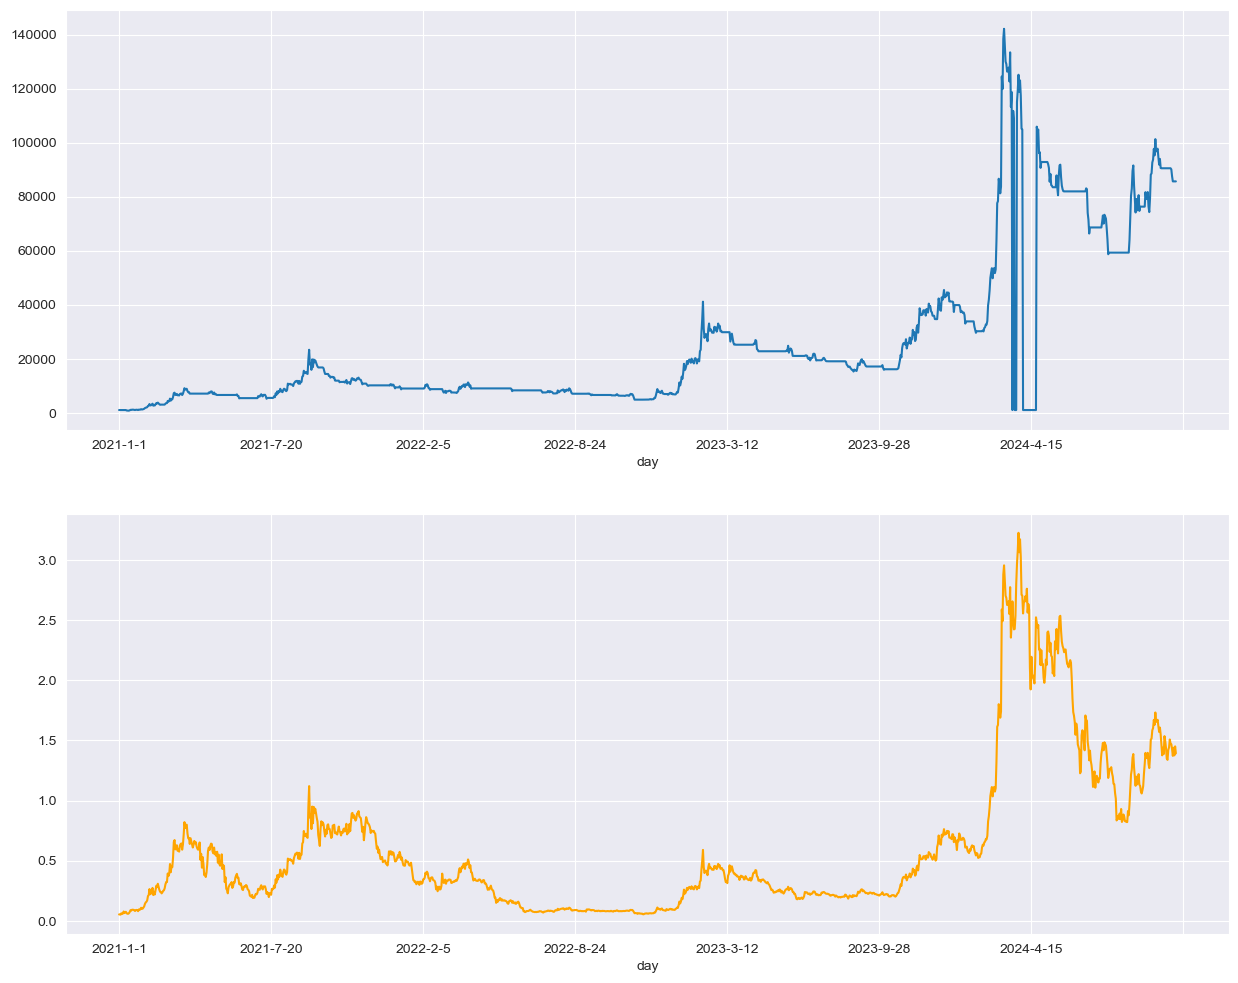

In [98]:
plots_wallet_vs_price(days_trade)

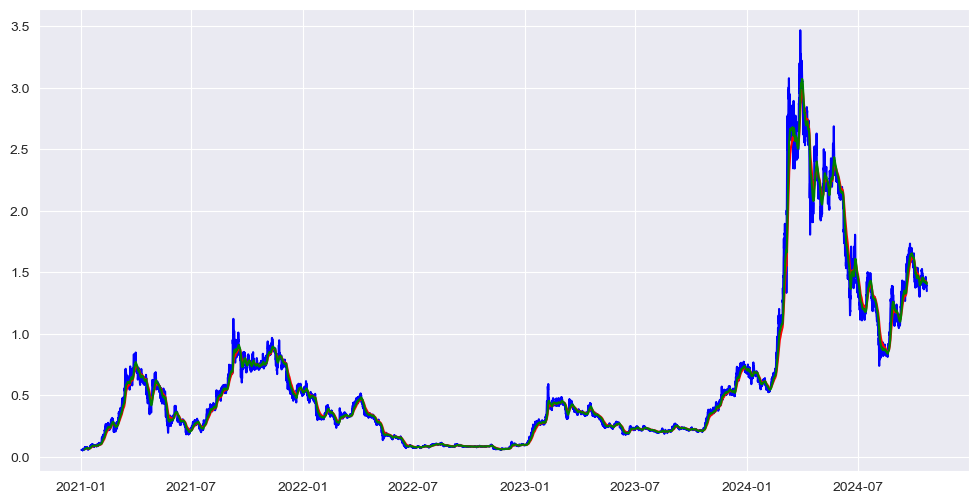

In [99]:
plt.figure(figsize=(12, 6))
plt.plot(df["close"],color = 'blue')
plt.plot(df["ema50"],color = 'red')
plt.plot(df['ema30'],color = 'green')
plt.grid(True)
plt.show()